In [12]:
from pandas import read_csv, DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib import pyplot
from numpy import array
from google.colab.drive import mount
from numpy import concatenate

In [13]:
mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
df = read_csv('/content/cpi.csv', usecols=['Date','CPI'])
df.head()

,Date,CPI
0,1995-1,103.8
1,1996-1,100.9
2,1997-1,100.8
3,1998-1,101.6
4,1999-1,101.7


In [15]:
min = df['CPI'].min()
max = df['CPI'].max()
df['CPI'] = (df['CPI'] - min) / (max - min)

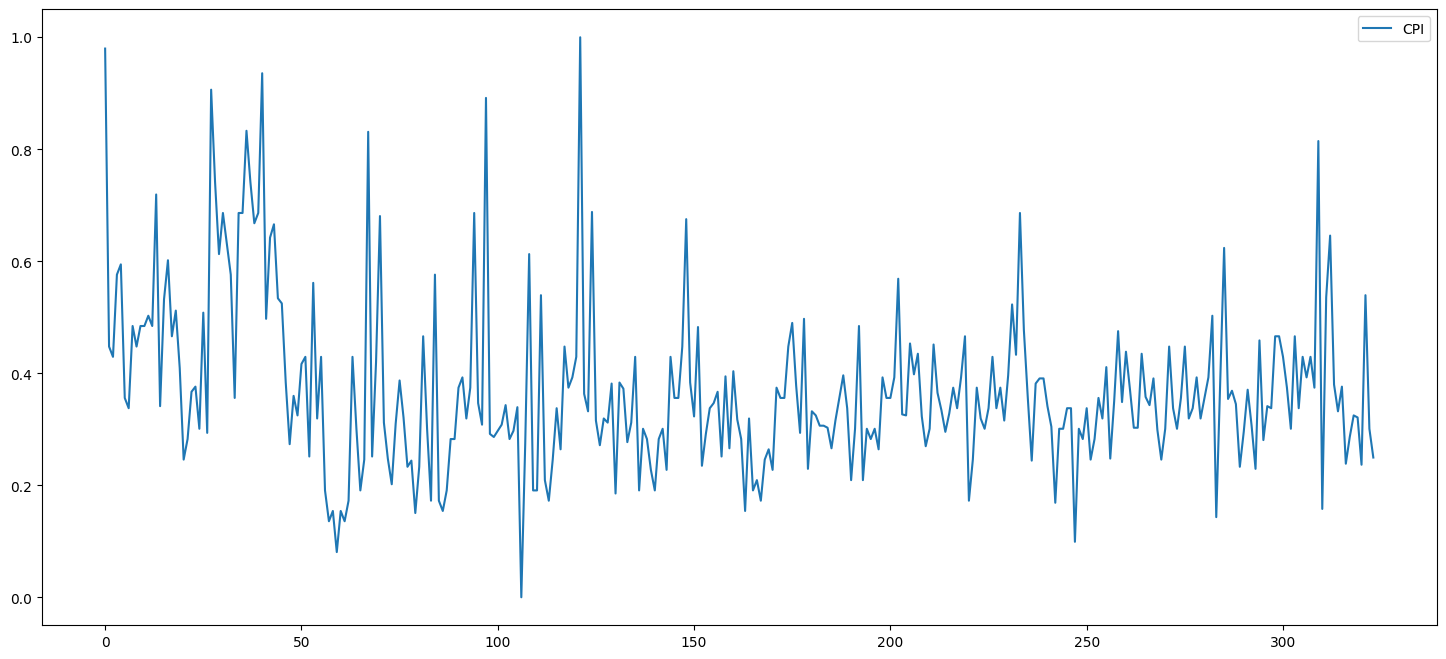

In [16]:
df.plot(figsize = (18, 8))
pyplot.show()

In [19]:
def split_sequence(arr, n_steps):
    X = []
    for i in range(len(arr) - n_steps):
        X.append(arr[i:i + n_steps])
    return array(X), array(arr[n_steps:])

In [21]:
n_steps = 6
X, y = split_sequence(df['CPI'].values, n_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=False)

In [22]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dense(1))
model.compile(optimizer = Adam(learning_rate = 0.001),loss = 'mse', metrics=['mse'])
#model.compile(optimizer = 'adam',loss = 'mse', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             4992      
                                                                 
 dense (Dense)               (None, 1, 1)              33        
                                                                 
Total params: 5025 (19.63 KB)
Trainable params: 5025 (19.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
result = model.fit(X_train, y_train, epochs = 1000, batch_size=1, validation_data=(X_test, y_test))

Epoch 1/1000
238/238 [==============================] - 2s 3ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 2/1000
238/238 [==============================] - 0s 2ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 3/1000
238/238 [==============================] - 0s 2ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 4/1000
238/238 [==============================] - 0s 2ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 5/1000
238/238 [==============================] - 0s 2ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6/1000
238/238 [==============================] - 0s 2ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 7/1000
238/238 [==============================] - 0s 2ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 8/1000
238/238 [==============================] - 0s 2ms

In [24]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [26]:
y_pred = y_pred.flatten()
mean_squared_error(y_test, y_pred)

0.01193376376004011

In [27]:
r2_score(y_test, y_pred)

-0.06869982673656527

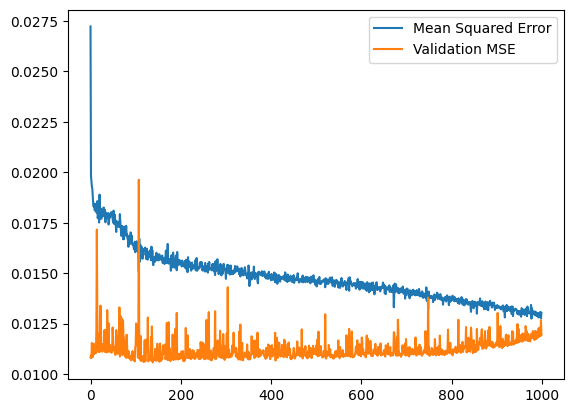

In [28]:
#result.history.keys()
import numpy as np
pyplot.plot(result.history['mse'], label='Mean Squared Error')
pyplot.plot(result.history['val_mse'], label='Validation MSE')
pyplot.legend()
pyplot.show()

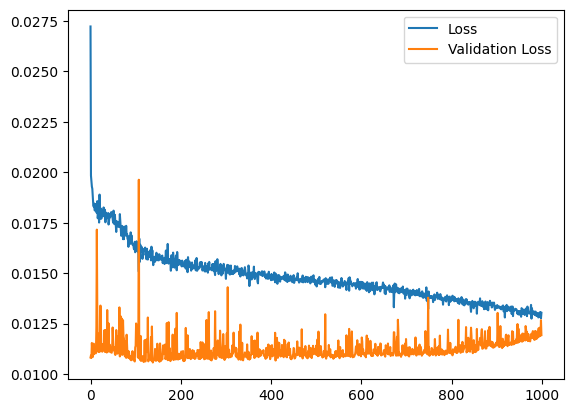

In [29]:
pyplot.plot(result.history['loss'], label='Loss')
pyplot.plot(result.history['val_loss'], label='Validation Loss')
pyplot.legend()
pyplot.show()

In [30]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
#y_train_pred.flatten()
pred = concatenate((y_train_pred.flatten(), y_test_pred.flatten())) * (max - min) + min
dic = {'Date': df.index[n_steps:], 'Actual': y * (min - max) + min, 'Pred': pred}
df_result = DataFrame(data = dic)
df_result.tail(10)

3/3 [==============================] - 0s 3ms/step


,Date,Actual,Pred
308,314,96.65,99.987305
309,315,96.41,100.287064
310,316,97.16,99.653389
311,317,96.90,100.369576
312,318,96.69,100.169907
313,319,96.71,100.188301
314,320,97.17,100.184532
315,321,95.52,100.272667
316,322,96.82,100.171860
317,323,97.10,100.423286


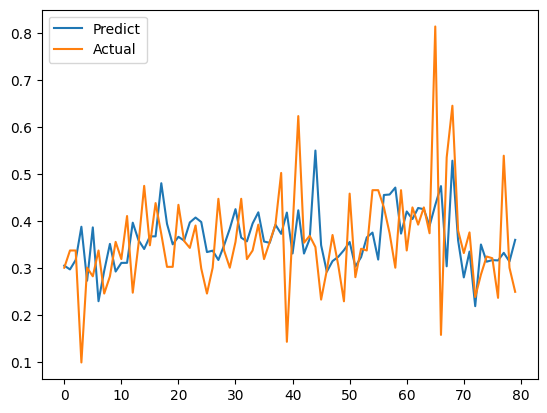

In [31]:
pyplot.plot(y_pred, label='Predict')
pyplot.plot(y_test, label='Actual')
pyplot.legend()
pyplot.show()

In [98]:
class WindowGenerator:
  def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, label_columns=None):

    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])